# STAT2005 Computer Simulation 

## Lecture 6 - Value-at-Risk (VaR) 

**Felix Chan, School of Economics and Finance**

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as sps
import matplotlib.pyplot as plt
import pandas as pd
import copy as copy

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize']=[9,6]

### Stock Prices

- Financial market is difficult to predict. 
- Let's focus on stock (equity) prices for the time being. 
- Companies (publicly held or listed) offer part of their ownerships (shares). 
- The value of share is determined by the market (demand vs. supply). 
- Let take an example. 

In [3]:
stock = pd.read_csv('stock201801-Sem1.csv', header=0, index_col=0)
stock.head()

,AAPL,HPQ,INTC,MSFT
Date,,,,
2004-08-02,31.58,20.37,24.90,28.52
2004-08-03,31.29,20.25,24.17,28.07
2004-08-04,31.79,20.44,23.97,28.06
2004-08-05,31.39,20.50,23.67,27.53
2004-08-06,29.78,19.90,22.77,27.14


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a0b9cf8>,
      dtype=object)

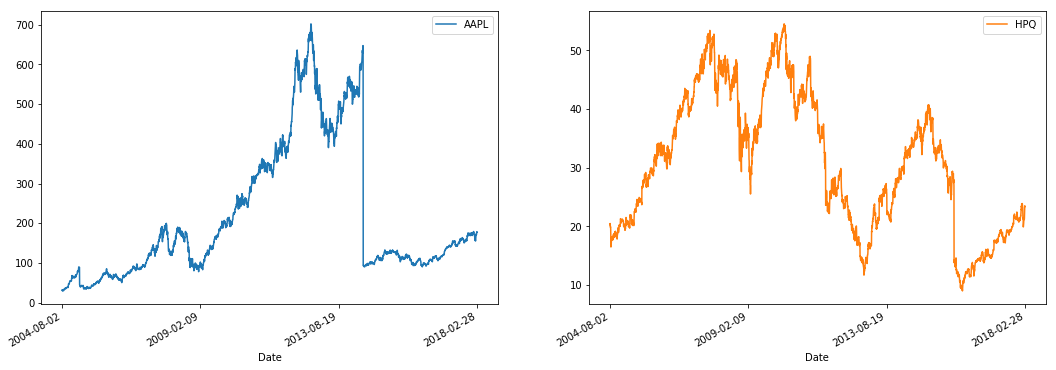

In [4]:
T = len(stock.index)
select = [int(i) for i in np.linspace(0,T-1,4)]
stock.loc[:,['AAPL', 'HPQ']].plot(subplots=True, layout=(1,2), figsize=[18,6], xticks=select)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a210518>,
      dtype=object)

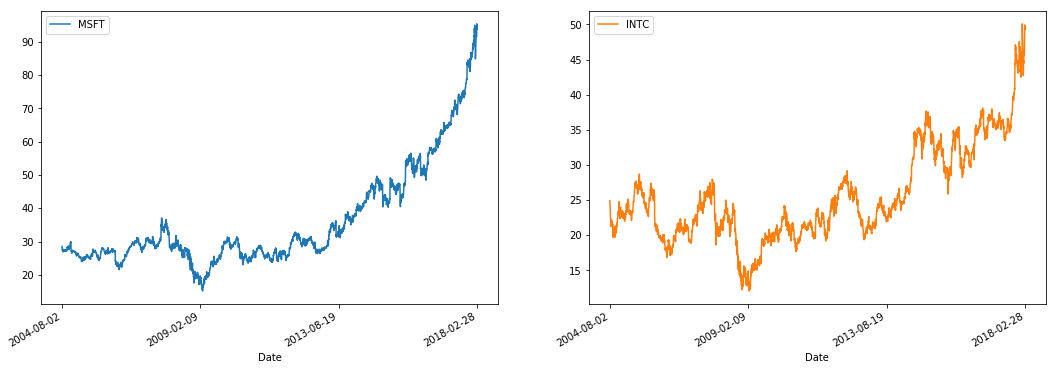

In [5]:
stock[['MSFT', 'INTC']].plot(subplots=True, layout=(1,2), figsize=[18,6], xticks=select)

### Predictability 

- Are these predictable? 
- This is a difficult question to answer. What are we trying to predict? 
- The price level? 


- A common belief is that stock price follows a random walk with drift. Let $P_t$ denotes the stock price at time $t$ then

$$ \log P_t = \alpha + \log P_{t-1} + u_t.$$
- What wrong with that? 
- Let $p_t = \log P_t$, 

then 
$$ 
    \begin{align}
        \log P_t =& \alpha + \log P_{t-1} + u_t \\
        p_t =& \alpha + p_{t-1} + u_t \\
        p_1 =& \alpha + p_0 + u_1 \\
        p_2 =& \alpha + p_1 + u_2 \\
        =& 2\alpha + p_0 + u_1 + u_2 \\
        &\vdots \\
        p_t =& \alpha t + p_0 + \sum^t_{i=1} u_i
     \end{align} 
$$

- What does this process look like?
- We can simulate it!!  

In [6]:
def RW(N, a=0, p0=0, sigma=0.01):
    u = sps.norm.rvs(scale=sigma, size=N)
    U = np.cumsum(u)
    p = np.array([a*t + p0 + e for t,e in enumerate(U)])
    return p, np.exp(p)

- Extract the parameter values from real data. 
- Use the first observation of the data as $p_0$ and note that $\log P_t - \log P_{t-1} = \alpha + u_t$, so $\sigma$ can be extracted by the sample variance of the *log-difference* of the stock price. 
- The sample mean of the *log-difference* can be used for $\alpha$. 

In [93]:
s = 'MSFT'
p0, sigma = np.log(stock[s].values[0]), np.log(stock[s]).diff().std()
a = np.log(stock[s]).diff().mean()
p,P = RW(1000,a=a,p0=p0,sigma=sigma)

In [94]:
plt.rcParams['figure.figsize'] = [18,6]

([<matplotlib.lines.Line2D at 0x11648ca58>], Text(0.5,1,'Simulated Price'))

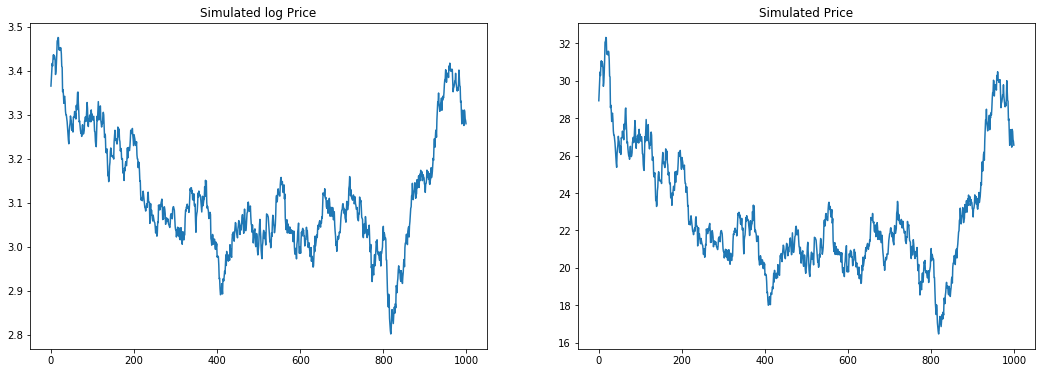

In [95]:
plt.subplot(1,2,1)
plt.plot(p), plt.title('Simulated log Price')
plt.subplot(1,2,2)
plt.plot(P), plt.title('Simulated Price')

- This is only one *realization*
- We can do a few more to see how this process can generate drastically different observations. 

([<matplotlib.lines.Line2D at 0x113598588>], Text(0.5,1,'Simulated Price'))

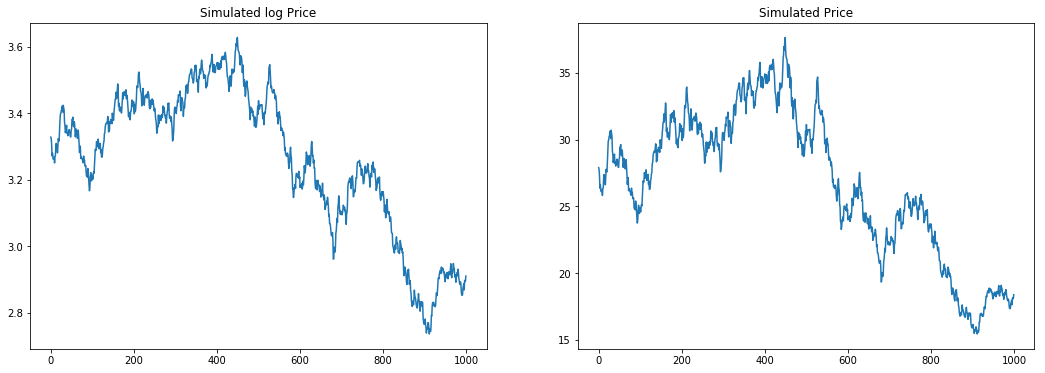

In [96]:
p,P = RW(1000,a=a,p0=p0,sigma=sigma)
plt.subplot(1,2,1)
plt.plot(p), plt.title('Simulated log Price')
plt.subplot(1,2,2)
plt.plot(P), plt.title('Simulated Price')

([<matplotlib.lines.Line2D at 0x1134bab70>], Text(0.5,1,'Simulated Price'))

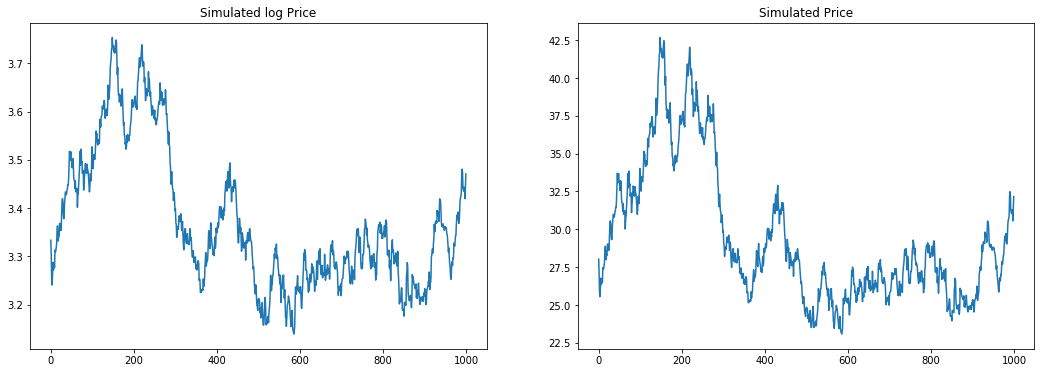

In [97]:
p,P = RW(1000,a=a,p0=p0,sigma=sigma)
plt.rcParams['figure.figsize'] = [18,6]
plt.subplot(1,2,1)
plt.plot(p), plt.title('Simulated log Price')
plt.subplot(1,2,2)
plt.plot(P), plt.title('Simulated Price')

([<matplotlib.lines.Line2D at 0x11352d828>], Text(0.5,1,'Simulated Price'))

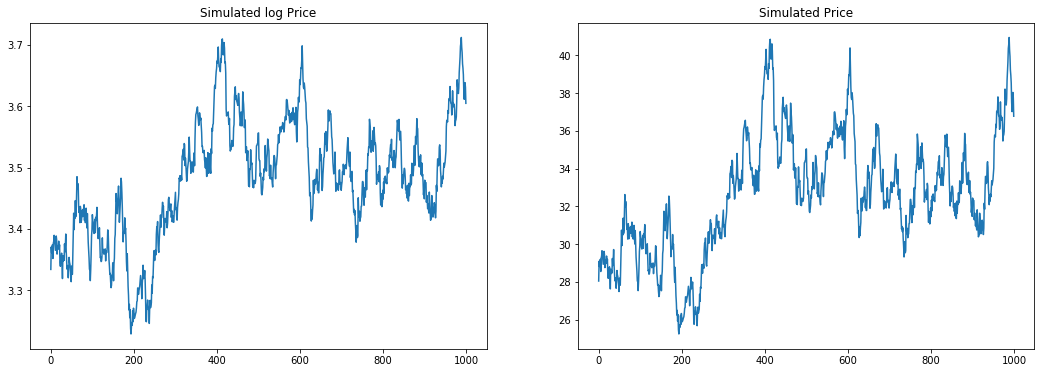

In [98]:
p,P = RW(1000,a=a,p0=p0,sigma=sigma)
plt.rcParams['figure.figsize'] = [18,6]
plt.subplot(1,2,1)
plt.plot(p), plt.title('Simulated log Price')
plt.subplot(1,2,2)
plt.plot(P), plt.title('Simulated Price')

([<matplotlib.lines.Line2D at 0x1135dfb00>], Text(0.5,1,'Simulated Price'))

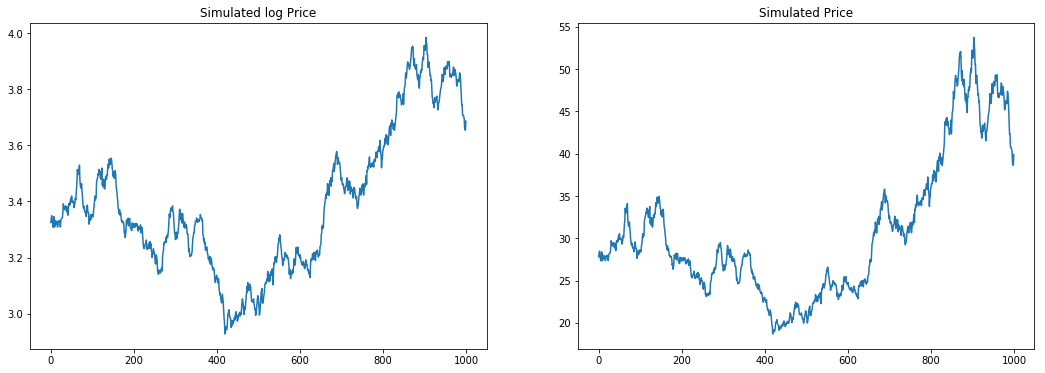

In [99]:
p,P = RW(1000,a=a,p0=p0,sigma=sigma)
plt.rcParams['figure.figsize'] = [18,6]
plt.subplot(1,2,1)
plt.plot(p), plt.title('Simulated log Price')
plt.subplot(1,2,2)
plt.plot(P), plt.title('Simulated Price')

- Under the random walk assumption, how well can we predict stock price? 
- Let's do some calculation. Recall 
$$ p_{t+1} = \alpha + p_{t} + u_{t+1}, \qquad u_t \sim IID(0,\sigma^2)$$ 
then the best predictor for stock price is $\alpha + p_t$ which is today price plus the drift term. 
- However, consider the variance of $p_t$,
$$ \begin{align} Var(p_t) =& \mathbb{E} \left [ p_t - \mathbb{E} (p_t) \right ]^2 \\
 =& \mathbb{E} \left ( \sum^t_{i=1} u_i \right )^2 \\
 =& \sigma^2 t
 \end{align}
$$
The second line follows from the fact that $p_t = \alpha t + p_0 + \sum^t_{i=1} u_i$. 
- As $t\rightarrow \infty$, $Var(p_t) \rightarrow \infty$.
- An implication is that, while one can obtain point forecasts for stock price, one cannot predict them with any degree of certainty. 

### Trading

- Prediction of stock price allows one to construct optimal trading strategy. 
- This may not be possible as we see above. 
- A second best approach is to consider the following: 
    - Assume we trade on a daily frequency, that is, we buy at the beginning of a day and sell at the beginning of the next day, what would be my profit/loss (also known as *returns*). 
    - This leads to a transformation of the data. The return at time $t$ is 
$$r_t = \log \left ( \frac{P_t}{P_{t-1}} \right ). $$ 

This is just a *first difference* in $\log$ (also known as *log-difference*). How does this work? 
$$ \begin{align} \log \left ( \frac{P_t}{P_{t-1}} \right ) =& \log \left ( 1+\frac{P_t}{P_{t-1}} -1\right ) \\
                                                            =& \log \left ( 1+\frac{P_t-P_{t-1}}{P_{t-1}}\right ) \\
                                                            \approx & \frac{P_t-P_{t-1}}{P_{t-1}}
    \end{align}
$$
- The last line follows from the fact that $\log (1+x) \approx x$ by Taylor series. 

Why do we do this? 

This is partly motivated by the continuous time literature. Let $W_t = \int^t_0 u_t dt$, then 

$$ \begin{align} 
    p_t =& \alpha t + p_0 + W_t \\
    p_{t+\Delta t} =& \alpha (t+\Delta t) + p_0 + W_{t+\Delta t} \\
    p_{t+\Delta t} -  p_t =& \alpha \Delta t + W_{t+\Delta t}-W_t \\
    dp_t =& \alpha dt + dW_t \qquad \Delta t \rightarrow 0 \\
    \frac{dP_t}{P_t} =& \alpha dt + dW_t
    \end{align}
$$

So the log-difference is trying to approximate 
$$ \frac{P_t-P_{t-\Delta t}}{P_{t-\Delta t}}.$$


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a6d6748>,
      dtype=object)

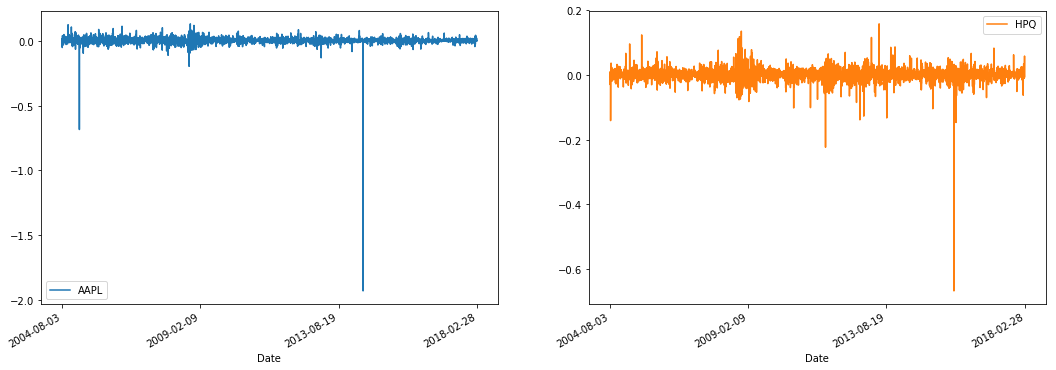

In [7]:
dstock = np.log(stock).diff()
dstock = dstock.iloc[1:dstock.shape[0],:]
T = len(dstock.index)
select = [int(i) for i in np.linspace(0,T-1,4)]
dstock.loc[:,['AAPL', 'HPQ']].plot(subplots=True, layout=(1,2), figsize=[18,6], xticks=select)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10a72f048>,
      dtype=object)

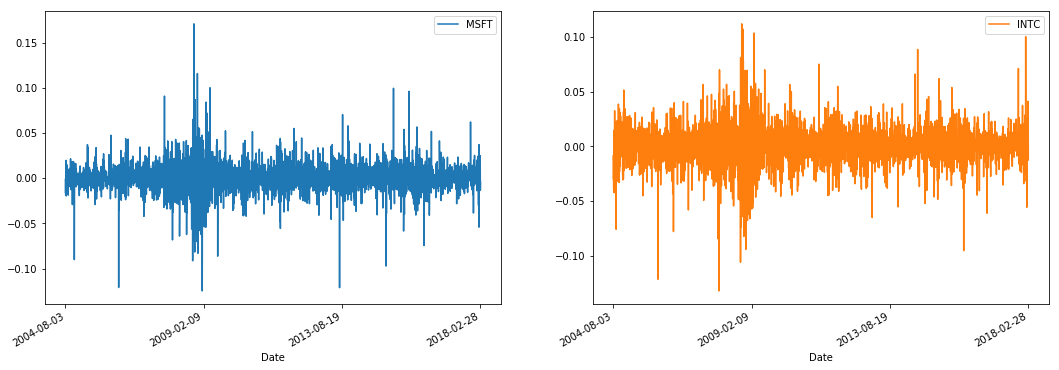

In [8]:
dstock.loc[:,['MSFT', 'INTC']].plot(subplots=True, layout=(1,2), figsize=[18,6], xticks=select)

In [9]:
print("The descriptive statistics are")
print(dstock.describe())
print('The skewness and kurtosis for each stock are')
temp = pd.DataFrame(np.c_[dstock.skew(), dstock.kurtosis()].transpose(), columns=dstock.columns, index=['skewness', 'kurtosis'])
print(temp)

The descriptive statistics are
              AAPL          HPQ         INTC         MSFT
count  3415.000000  3417.000000  3415.000000  3417.000000
mean      0.000500     0.000040     0.000199     0.000348
std       0.040845     0.023205     0.017797     0.016341
min      -1.930035    -0.667514    -0.132210    -0.124579
25%      -0.008475    -0.008741    -0.008808    -0.006961
50%       0.000995     0.000434     0.000522     0.000117
75%       0.011807     0.009938     0.009221     0.007865
max       0.130194     0.157845     0.111988     0.170626
The skewness and kurtosis for each stock are
                 AAPL         HPQ      INTC       MSFT
skewness   -32.338077   -7.324947 -0.192447   0.030293
kurtosis  1485.261506  206.422947  5.667252  11.273727


### Properties of Financial Returns

- The graphs and descriptive statistics above are typical of financial returns, including equities, commodities and exchange rates. 
- Some of the characteristics are:
    - Appears to have constant mean (trend disappeared) around zero. 
    - Lots of outliers and extreme observations. 
    - Clustering - big (small) movements tend to "cluster" together. 
    - Extremely high kurtosis. Recall the kurtosis of a normal distribution is 3. 


### Value-at-Risk 

- High number of extreme observations and outliers means the likelihood of losing a lot of money is high. 
- From the regulatory perspective, it is essential to ensure the banks have sufficient funds to cover their loses. 
- How to do that given the returns for tomorrow is unknown? 
- Create a forecasts to predict a "worst" case scenario. Then require the banks to put away three times that amount (just to be safe). 
- The "worst" case scenario here is defined as:
    $$ VaR (r_t ) = \sup \left \{ r \in \mathbb{R}: F(r_t) < r = \alpha \right \}$$  
   where $F(r_t)$ denotes the cumulative probability distribution of returns at time $t$ and $\alpha$ is the fixed probability of lost.  
- This is a simplified version of the *Basel Accord*. 

- How do we forecast a "worse" case scenario?
- Essentially we are looking at the lower end of the confident intervals of our return forecasts with $2\alpha$ being the significance level. 
- To demonstrate the idea, let's impose two additional assumptions about financial returns. 
    1. constant mean (possibly efficient market)
    2. constant volatility 
- The implication of the first assumption is that $\mathbb{E} (r_t) = \mu$ for all $t$ with $\mu=0$ under market efficiency. 
- The second assumption is that $Var(r_t) = \sigma^2 > 0$ for all $t$. 
- Together it implies that the "standardized" returns should be 
$$\frac{r_t - \mu}{\sigma} \sim D(0,1)$$
for some distribution $D$, but what is that distribution? 

- Perhaps we can get some idea from the histogram of the standardized returns in our data.  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10afe0c88>,
      dtype=object)

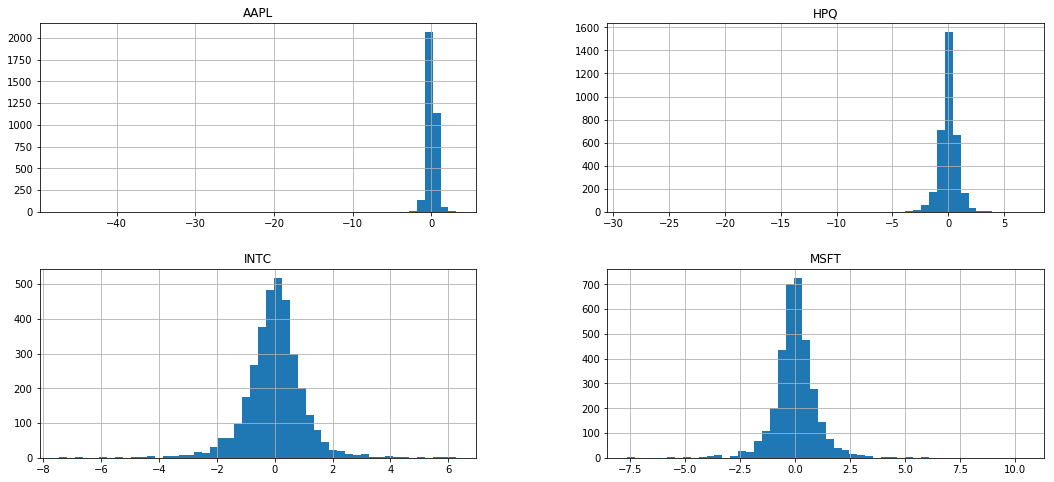

In [10]:
plt.rcParams['figure.figsize'] = [18,8]
sdstock = (dstock-dstock.mean())/dstock.std()
sdstock.hist(bins=50)

In [11]:
print("Descriptive statistics for the standardised data")
print(sdstock.describe())
print("The skewness and kurtosis of the standardised data")
temp = pd.DataFrame(np.c_[sdstock.skew(), sdstock.kurtosis()].transpose(), columns=sdstock.columns, index=['Skewness', 'Kurtosis'])
print(temp)

Descriptive statistics for the standardised data
               AAPL           HPQ          INTC          MSFT
count  3.415000e+03  3.417000e+03  3.415000e+03  3.417000e+03
mean  -2.460412e-17 -1.087642e-17 -2.454519e-17  1.486471e-17
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
min   -4.726473e+01 -2.876767e+01 -7.439887e+00 -7.645102e+00
25%   -2.197142e-01 -3.784127e-01 -5.060868e-01 -4.472809e-01
50%    1.213556e-02  1.696053e-02  1.816345e-02 -1.417700e-02
75%    2.768422e-01  4.265244e-01  5.069129e-01  4.599858e-01
max    3.175272e+00  6.800438e+00  6.281243e+00  1.042039e+01
The skewness and kurtosis of the standardised data
                 AAPL         HPQ      INTC       MSFT
Skewness   -32.338077   -7.324947 -0.192447   0.030293
Kurtosis  1485.261506  206.422947  5.667252  11.273727


- Note that neither skewness nor kurtosis has changed due to the standardization. 
- This is to be expected, because both statistics are standardized. 
$$ skewness = \frac{\mathbb{E} (r_t - \mu )^3}{\sigma^3} \qquad kurtosis = \frac{\mathbb{E} (r_t - \mu )^4}{\sigma^4}$$
Sometimes *kurtosis* is defined as *excess kurtosis* relative to the kurtosis of the normal distribution:
$$kurtosis = \frac{\mathbb{E} (r_t - \mu )^4}{\sigma^4}-3.$$

- How do we forecast VaR? 
- One approach is *historical simulation* (amongst the most popular method in the banking industry). 
    1. Assuming we begin with $T$ observations with a fixed $\alpha$ value (normally 1%).  
    2. Sort the $T$ returns from smallest to largest. Select the $int(\alpha T)^{th}$ observations as the VaR. 
    3. Go back to (1) for $T+2$ at $T+1$. 


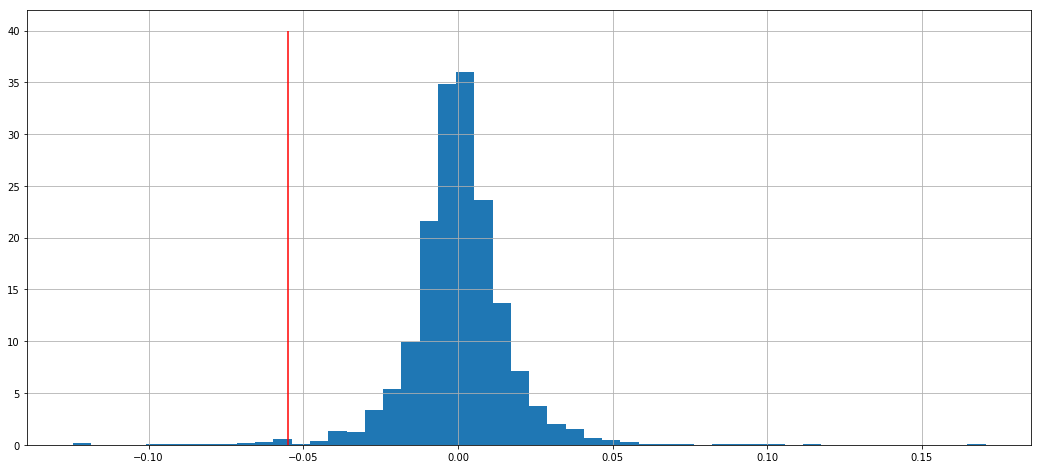

In [12]:
dstock['MSFT'].hist(bins=50, density=True)
plt.vlines(-0.055, ymin=0, ymax=40, color='r')

In [13]:
def HS_VaR(s, subsample, alpha=0.01, fixedwindows=False):
    """
    Function to construct VaR via historical simulation assuming constant mean and variance. 
    Inputs:
        s: (T,) numpy array containing financial returns data. 
        subample: float in [0,1]. Propotion of the sample to be used for construction the initial VaR. 
        alpha: float in [0,1]. Significant level. 
        fixedwindows: boolean. If true, the number of observations for calculating the critical value is fixed otherwise, we have a rolling windows. 
    Output:
        sT: int. The observation where the forecast starts. 
        VaR: (T,) numpy array containing the fitted and forecast VaR. 
    
    """
    T = s.shape[0]
    sT = int(np.floor(subsample*T))
    r = copy.copy(s[0:sT])
    VaR = np.zeros(T)
    r.sort()
    index = int(np.floor(alpha*sT))
    VaR[0:sT] = r[index]
    for t in np.arange(sT,T):
        if fixedwindows is False:
            r = copy.copy(s[0:t])
            r.sort()
            index = int(np.floor(alpha*t))
        else:
            r = copy.copy(s[t-sT:t])
            r.sort()
            index = int(np.floor(alpha*sT))
        VaR[t] = r[index]
    return sT, VaR

In [14]:
MSFT = dstock['MSFT'].values
subsample = 252/dstock.shape[0]
sT, dstock['VaR_MSFT_recursive']  = HS_VaR(MSFT, subsample=subsample)
sT, dstock['VaR_MSFT_rolling'] = HS_VaR(MSFT, subsample=subsample, fixedwindows=True) 

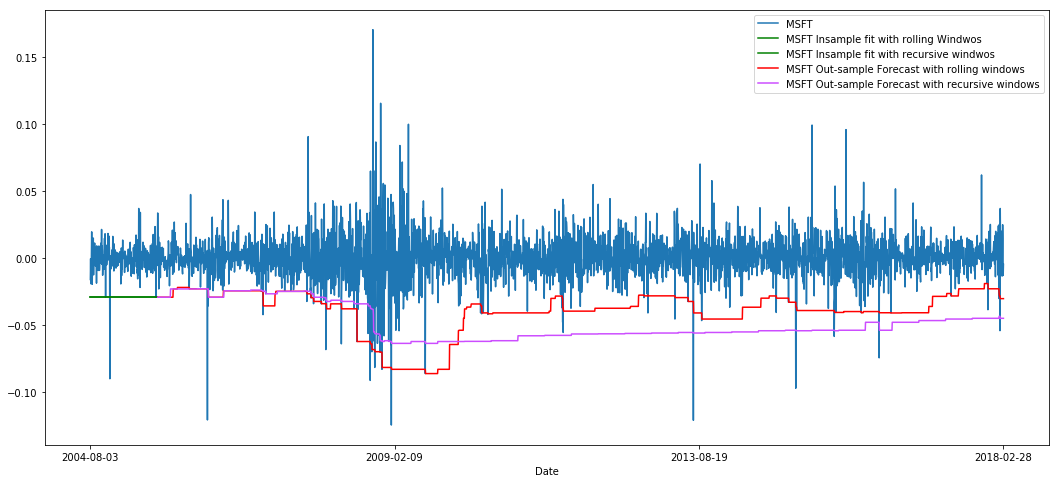

In [15]:
select = [int(np.floor(i)) for i in np.linspace(0,dstock.shape[0]-1,4)]
dstock['MSFT'].plot(xticks=select)
plt.plot(dstock['VaR_MSFT_rolling'].values[0:sT], 'g')
plt.plot(dstock['VaR_MSFT_recursive'].values[0:sT], 'g')
plt.plot(np.arange(sT, dstock.shape[0]), dstock['VaR_MSFT_rolling'].values[sT:], 'r')
plt.plot(np.arange(sT, dstock.shape[0]), dstock['VaR_MSFT_recursive'].values[sT:], color=(0.8,0.3,1))
plt.legend(['MSFT', 'MSFT Insample fit with rolling Windwos', 'MSFT Insample fit with recursive windwos', 'MSFT Out-sample Forecast with rolling windows', 'MSFT Out-sample Forecast with recursive windows'])

- So how well did that work? 
- If it works, there should only be around 1% of the observations go below the VaR forecast. 
$$ \% \text{Violation} = \frac{ \# (r_t < VaR_t)}{T}$$

In [16]:
backtest = pd.DataFrame(index=['Percentage of violation'])
backtest['backtest_insample_rolling'] = 100*np.mean(dstock['MSFT'].values[1:sT] <dstock['VaR_MSFT_rolling'].values[1:sT] )
backtest['backtest_outsample_rolling ']= 100*np.mean(dstock['MSFT'].values[sT:] <dstock['VaR_MSFT_rolling'].values[sT:] )
backtest['backtest_insample_recursive'] = 100*np.mean(dstock['MSFT'].values[1:sT] <dstock['VaR_MSFT_recursive'].values[1:sT] )
backtest['backtest_outsample_recursive'] = 100*np.mean(dstock['MSFT'].values[sT:] <dstock['VaR_MSFT_recursive'].values[sT:] )
backtest.transpose()

,Percentage of violation
backtest_insample_rolling,0.796813
backtest_outsample_rolling,1.421801
backtest_insample_recursive,0.796813
backtest_outsample_recursive,1.200632


- So within sample fits OK - but that is by construction. 
- Both methods exceeded the 1% threshold (but not by much). 
- However, 0.1% can still be economically significant. 
- Regulator may not be too happy about this. Why? 

- Basel Accord stipulates that banks have to reserve $(3+k)$ times the VaR to ensure they have sufficient funds to cover their lost. 
- $k > 0$ is a penalty factor. So if banks' VaR did not perform well in the past, they need to put away more. 

- Alternatively, we can calculate $c$ based on a known distribution rather than based on data. 
- But which distribution? 
- Let's try normal as a benchmark. 
$$ VaR = \hat{\mu} - c\hat{\sigma}$$
where $\hat{\mu}$ and $\hat{\sigma}$ denote the sample mean and standard deviation.  

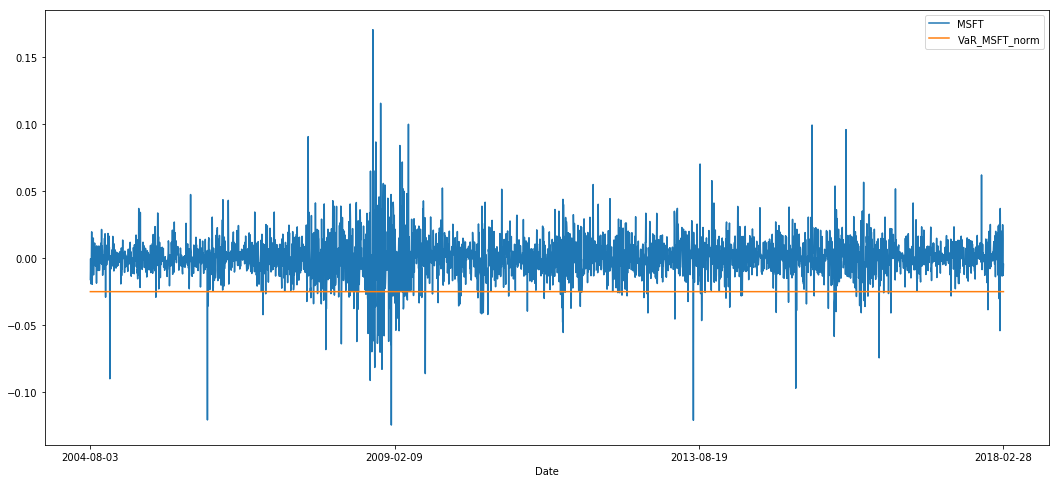

In [17]:
c, mu, sigma = sps.norm.isf(0.01), dstock['MSFT'].iloc[0:sT].mean(), dstock['MSFT'].iloc[0:sT].std()
dstock['VaR_MSFT_norm'] = mu - c*sigma
dstock.loc[:,['MSFT', 'VaR_MSFT_norm']].plot(xticks=select)

In [18]:
backtest['backtest_insample_norm'] = 100*np.mean(dstock['MSFT'].values[1:sT] <dstock['VaR_MSFT_norm'].values[1:sT] )
backtest['backtest_outsample_norm'] = 100*np.mean(dstock['MSFT'].values[sT:] <dstock['VaR_MSFT_norm'].values[sT:] )
backtest.transpose()

,Percentage of violation
backtest_insample_rolling,0.796813
backtest_outsample_rolling,1.421801
backtest_insample_recursive,0.796813
backtest_outsample_recursive,1.200632
backtest_insample_norm,1.195219
backtest_outsample_norm,4.486572


- The result for within sample is consistent with others. 
- The result for out-of sample is terrible! 
- What's going on? 
- Majority of the violations happens during the GFC! 
- How about if we estimate the mean and variance based on rolling windows and thus minimize the effects like GFC? 

In [19]:
def Rolling_VaR(s, subsample, alpha=0.01): 
    """
    Function to construct VaR via historical simulation assuming constant mean and variance. 
    Inputs:
        s: (T,) numpy array containing financial returns data. 
        subample: float in [0,1]. Propotion of the sample to be used for construction the initial VaR. 
        alpha: float in [0,1]. Significant level. 
    Outputs:
        sT: int. The observation where the forecast starts. 
        VaR: (T,) numpy array containing the fitted and forecast VaR. 
    """
    T = s.shape[0]
    sT = int(np.floor(subsample*T))
    VaR = np.zeros(T)
    c = sps.norm.isf(alpha)
    for t in np.arange(sT,T):
        r = copy.copy(s[t-sT+1:t+1])
        m = np.mean(r)
        sigma = np.var(r)
        VaR[t] = m - c*np.power(sigma,0.5)
    return sT, VaR

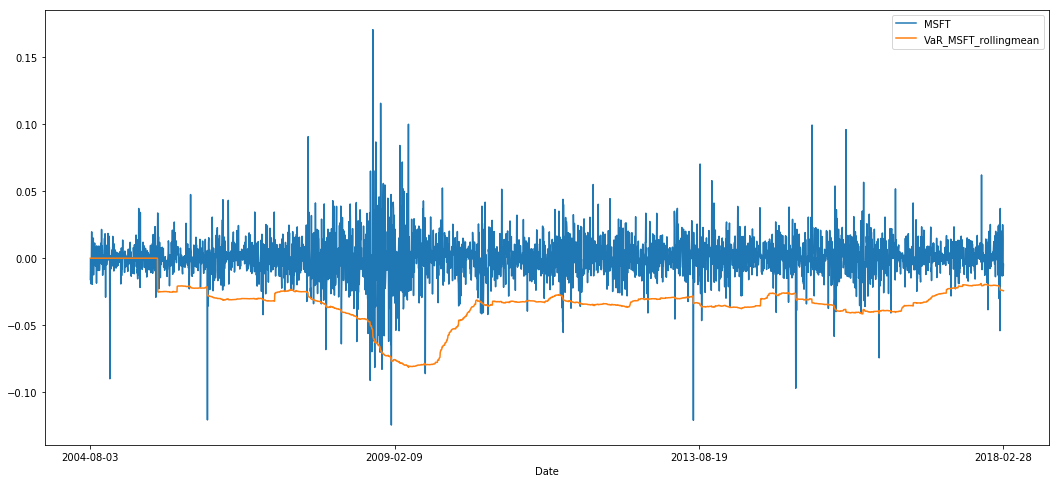

In [20]:
sT, dstock['VaR_MSFT_rollingmean'] = Rolling_VaR(dstock['MSFT'].values, subsample=subsample)
dstock[['MSFT', 'VaR_MSFT_rollingmean']].plot(xticks=select)

In [21]:
backtest['backtest_outsample_rollingmean'] = 100*np.mean(dstock['MSFT'].values[sT:] <dstock['VaR_MSFT_rollingmean'].values[sT:] )
backtest.transpose()

,Percentage of violation
backtest_insample_rolling,0.796813
backtest_outsample_rolling,1.421801
backtest_insample_recursive,0.796813
backtest_outsample_recursive,1.200632
backtest_insample_norm,1.195219
backtest_outsample_norm,4.486572
backtest_outsample_rollingmean,1.737757


- This does better but the percentage of violations is still too high. 
- Note that these are constructed under normality. 
- Perhaps we can use a distribution with slightly "thicker" tail. Such as $t(9)$. 

In [22]:
def Rolling_VaR_t(s, subsample, alpha=0.01, df=5): 
    """
    Function to construct VaR via historical simulation assuming constant mean and variance. 
    Inputs:
        s: (T,) numpy array containing financial returns data. 
        subample: float in [0,1]. Propotion of the sample to be used for construction the initial VaR. 
        alpha: float in [0,1]. Significant level. 
    Outputs:
        sT: int. The observation where the forecast starts. 
        VaR: (T,) numpy array containing the fitted and forecast VaR. 
    """
    T = s.shape[0]
    sT = int(np.floor(subsample*T))
    VaR = np.zeros(T)
    c = sps.t.isf(alpha, df=df)
    for t in np.arange(sT,T):
        r = copy.copy(s[t-sT+1:t+1])
        m = np.mean(r)
        sigma = np.var(r)
        VaR[t] = m - c*np.power(sigma,0.5)
    return sT, VaR

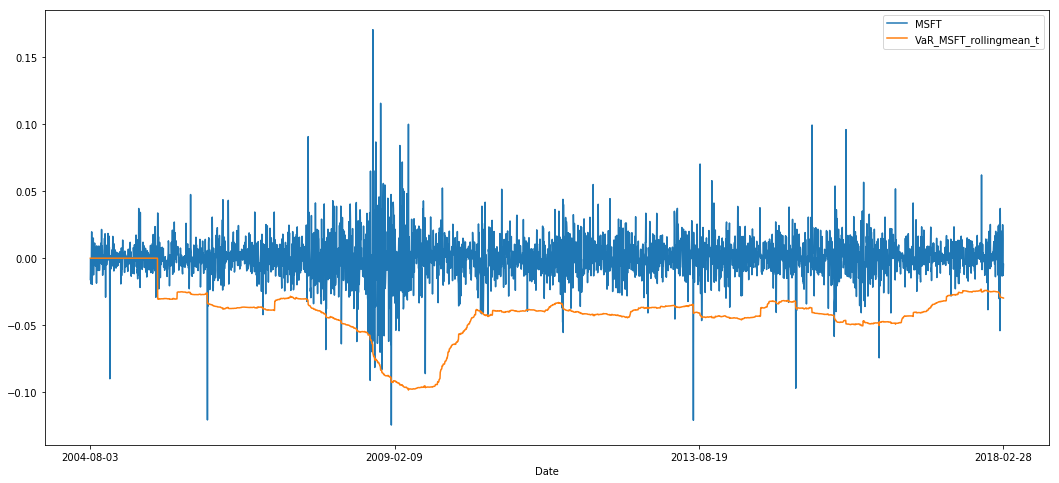

In [23]:
sT, dstock['VaR_MSFT_rollingmean_t'] = Rolling_VaR_t(dstock['MSFT'].values, subsample=subsample, df=9)
dstock.loc[:,['MSFT', 'VaR_MSFT_rollingmean_t']].plot(xticks=select)

In [24]:
backtest['backtest_outsample_rollingmean_t'] = 100*np.mean(dstock['MSFT'].values[sT:] <dstock['VaR_MSFT_rollingmean_t'].values[sT:] )
backtest.transpose()

,Percentage of violation
backtest_insample_rolling,0.796813
backtest_outsample_rolling,1.421801
backtest_insample_recursive,0.796813
backtest_outsample_recursive,1.200632
backtest_insample_norm,1.195219
backtest_outsample_norm,4.486572
backtest_outsample_rollingmean,1.737757
backtest_outsample_rollingmean_t,1.011058


### A little Summary
- So with a little bit of "calibration", we seems to be able to get a "close" enough "VaR" percentage. 
- Are we over-fitting them?
- Are we violating the initial assumptions of constant mean and variance?
- If so, is there a better way to model mean and variance other than rolling windows? 
